In [2]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "HSN", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/HSN", 
                       num_proc=1, 
                       revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

In [86]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
        num_rows: 5460
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
        num_rows: 10296
    })
    test_5s: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', '

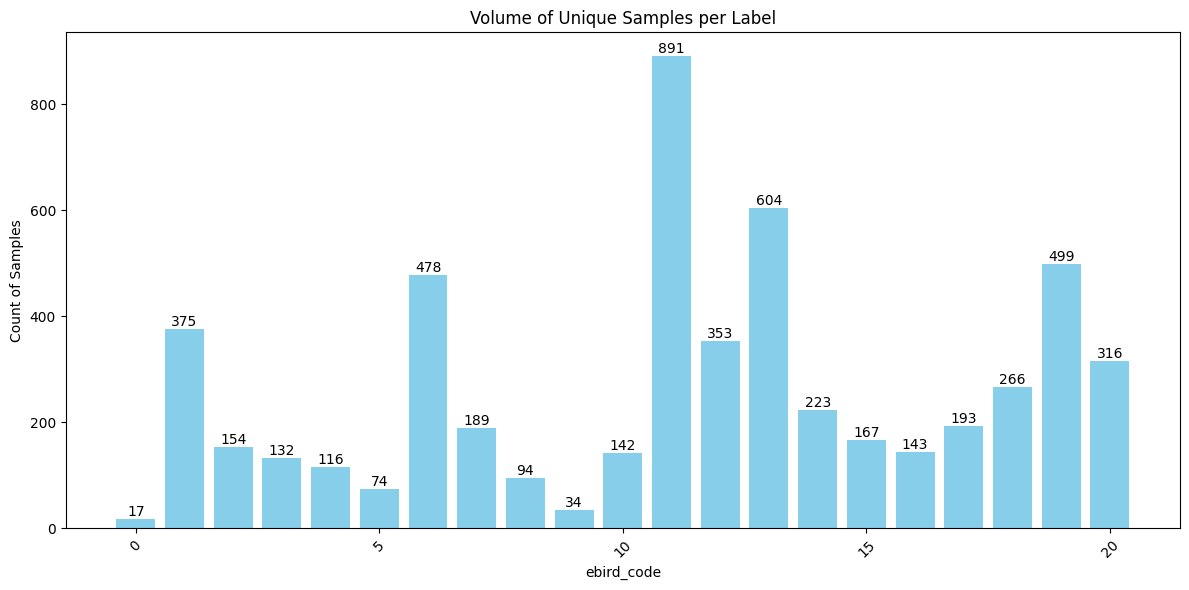

In [87]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [88]:
filtered_dataset = dataset["train"].filter(lambda example: example["length"] <= 5)
filtered_dataset = DatasetDict({
    "train": filtered_dataset,
    "test": dataset["test_5s"]
})

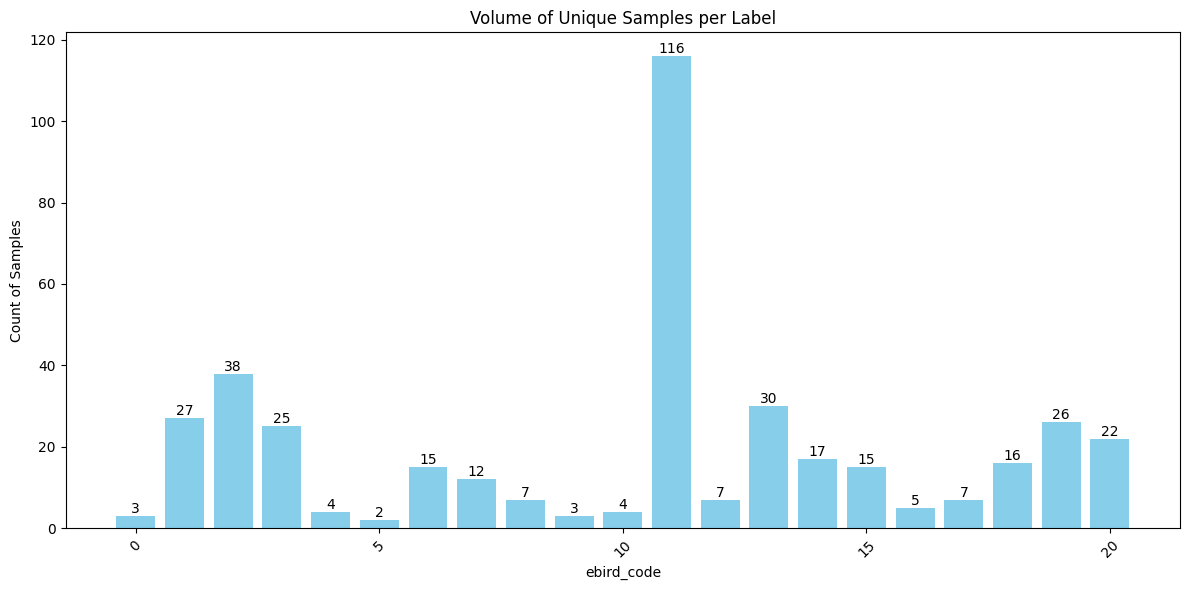

In [89]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

CREATE FEW-SHOT

In [1]:
# filtered without secondary 

filtered_dataset = dataset["train"].filter(
    lambda example: (example["length"] <= 5) or (example["length"] <= 20 and example["ebird_code_secondary"] == [])
)
filtered_dataset = DatasetDict({
    "train": filtered_dataset,
    "test": dataset["test_5s"]
})

filtered_dataset

NameError: name 'dataset' is not defined

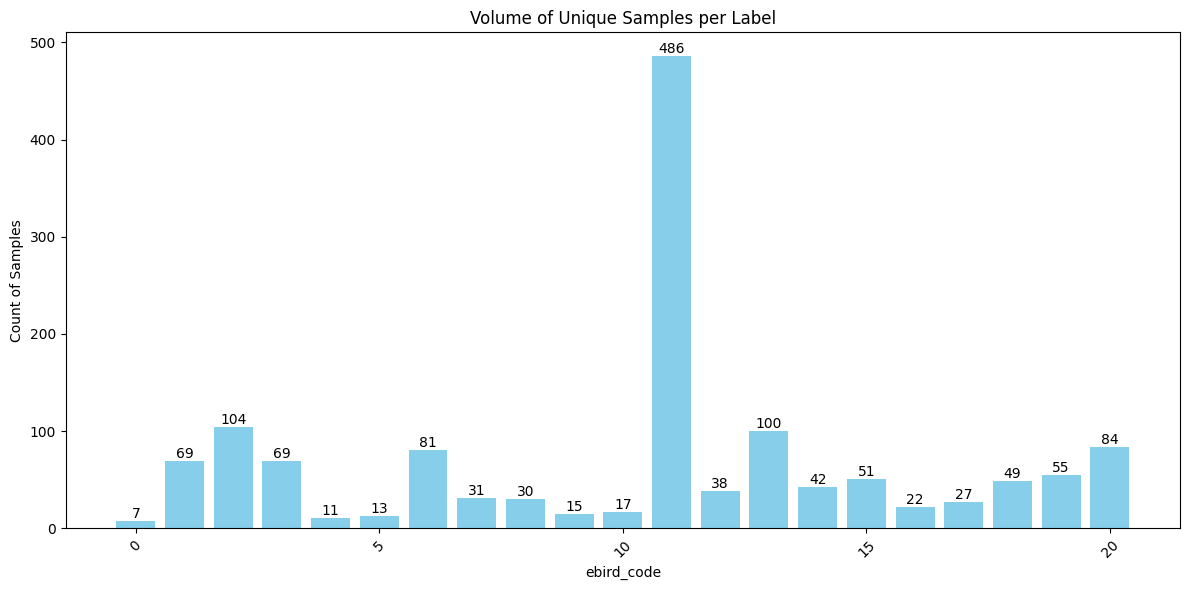

In [91]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [92]:
import random
from datasets import DatasetDict

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    in the train split, while leaving all other splits intact.
    
    Args:
        dataset_dict: A Hugging Face DatasetDict containing at least a "train" split.
        shot_count: The maximum number of samples to select per class from the train split.
        label_field: The key in each example that contains the class label (default: "ebird_code").
        
    Returns:
        A new Hugging Face DatasetDict where:
            - "train" is a few-shot subset of the original train split.
            - All other splits (e.g. "test") remain unchanged.
    """
    # Process the train split only.
    train_dataset = dataset_dict["train"]

    # Collect indices for each label in the train split.
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)

    # For each label, randomly sample up to shot_count indices.
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)

    # (Optional) Sort indices if you wish to maintain order.
    selected_indices.sort()

    # Create the few-shot train split.
    few_shot_train = train_dataset.select(selected_indices)

    # Create a new DatasetDict with the few-shot train split and keep the rest of the splits unchanged.
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train

    return new_dataset_dict

# Example usage:
# Suppose `new_dataset` is your DatasetDict with:
#   - "train": the filtered train split,
#   - "test": the unfiltered (renamed) test split.
shot_count = 4 # This can be set to 4, 8, 16, 32, etc.
filtered_dataset = create_few_shot_dataset_dict(filtered_dataset, shot_count)

# Optionally, inspect the new DatasetDict:
filtered_dataset

{'train': Dataset({
     features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
     num_rows: 84
 }),
 'test': Dataset({
     features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
     num_rows: 12000
 })}

In [93]:

from birdset.datamodule.components.event_mapping import XCEventMapping

print("casting columns", flush=True)
filtered_dataset["train"] = filtered_dataset["train"].cast_column(
    column="audio",
    feature=Audio(
        sampling_rate=32_000,
        mono=True,
        decode=False,
    ),
)

mapper = XCEventMapping()

print("event mapping", flush=True)
filtered_dataset["train"] = filtered_dataset["train"].map(
    mapper,
    remove_columns=["audio"],
    batched=True,
    batch_size=300,
    num_proc=3,
    desc="Train event mapping"
)

casting columns
event mapping


Train event mapping (num_proc=3):   0%|          | 0/84 [00:00<?, ? examples/s]

In [94]:
filtered_dataset

{'train': Dataset({
     features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
     num_rows: 126
 }),
 'test': Dataset({
     features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
     num_rows: 12000
 })}

In [ ]:
import random
from collections import defaultdict

def fewshot_sampling(dataset):
    # Force event_limit to 1: only one sample per file

    # Group sample indices by the file they come from.
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)

    # For each file, randomly select one sample.
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]

    return dataset.select(unique_file_indices)

# Example usage:
print("smart sampling", flush=True)
filtered_dataset["train"] = fewshot_sampling(
   dataset=filtered_dataset["train"],
)

columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]

# Create a new DatasetDict with the selected columns for each split
filtered_dataset = DatasetDict({
    split: filtered_dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
    for split, ds in filtered_dataset.items()
})

In [100]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 84
    })
    test: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 12000
    })
})

In [105]:
filtered_dataset["train"][3]

{'filepath': '/home/lrauch/projects/birdMAE/data/HSN/downloads/extracted/c5c353680d3e320a02098cae96594ac6ddf1db6c68b9de148e1c2feb0c6fd64a/XC509716.ogg',
 'labels': [11],
 'detected_events': [1.12, 2.624],
 'start_time': None,
 'end_time': None}

In [106]:
import torch 
def one_hot_encode_batch(batch, num_classes=21):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    
    Args:
        batch (dict): A dictionary containing a "labels" key with a list of integer labels.
        num_classes (int): The total number of classes.
        
    Returns:
        dict: A dictionary with the "labels" key replaced by a tensor of one-hot vectors.
    """
    # batch["labels"] is a list of integer labels.
    label_list = batch["labels"]
    batch_size = len(label_list)
    
    # Create a zero tensor of shape (batch_size, num_classes)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    
    # Set the appropriate indices to 1
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
        
    return {"labels": one_hot}

# Assume you already have a DatasetDict (e.g., new_dataset) with splits such as "train" and "test".
# Also, define the total number of classes.
num_classes = 21  # Replace with your actual number of classes

# Apply the one-hot encoding function to every split.
one_hot_dataset = filtered_dataset.map(one_hot_encode_batch, batched=True)

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

In [107]:
one_hot_dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 84
    })
    test: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 12000
    })
})

In [108]:
one_hot_dataset.save_to_disk("/home/lrauch/projects/birdMAE/data/HSN/HSN_4shot")

Saving the dataset (0/1 shards):   0%|          | 0/84 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

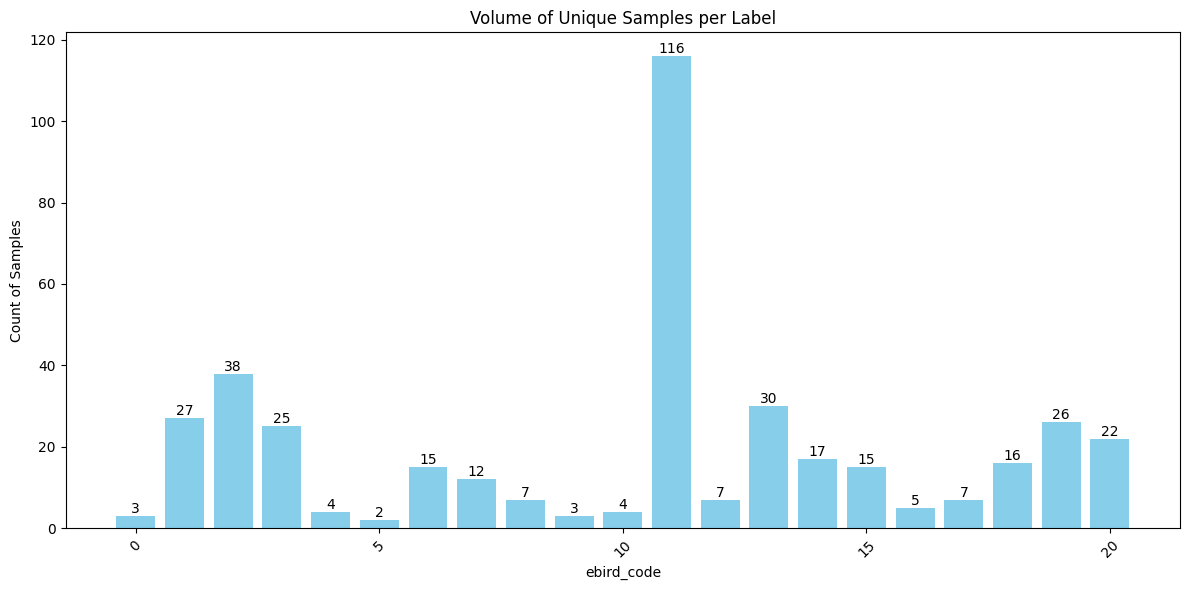

In [105]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [106]:
# filtered without secondary 

filtered_dataset = dataset["train"].filter(
    lambda example: (example["length"] <= 5) or (example["length"] <= 15 and example["ebird_code_secondary"] == [])
)
filtered_dataset = DatasetDict({
    "train": filtered_dataset,
    "test": dataset["test_5s"]
})

{'train': Dataset({
    features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
    num_rows: 306
}), 'test': Dataset({
    features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
    num_rows: 12000
})}


In [ ]:
few_shot_dataset[]

In [95]:
label_to_indices

{}

In [87]:
16*21

336

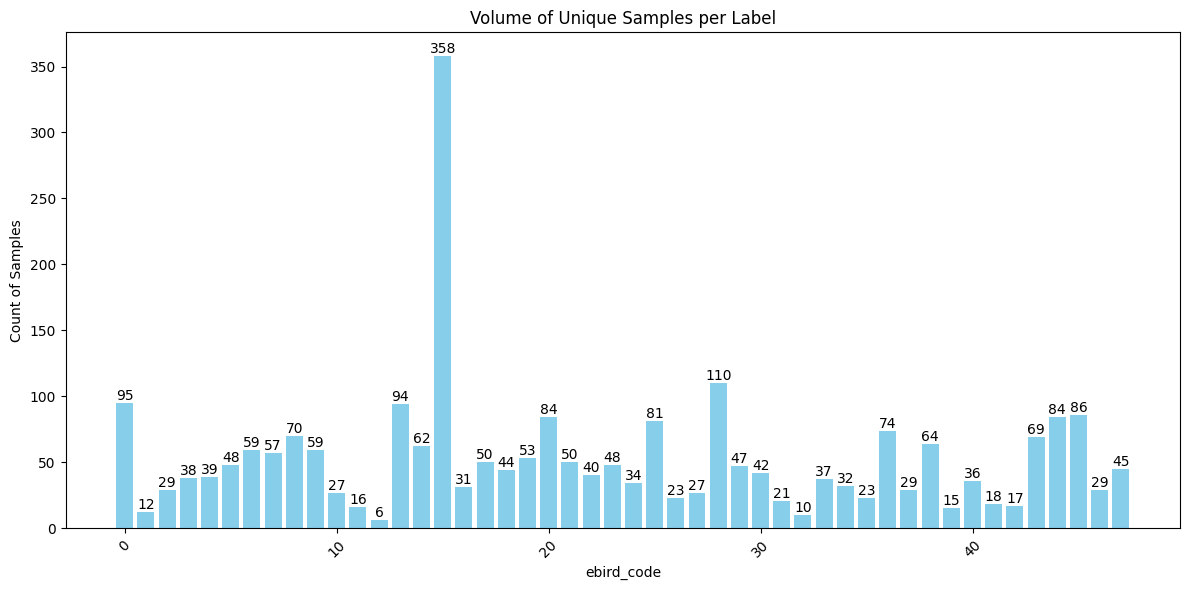

In [80]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

## POW

In [7]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "POW", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/POW", 
                       num_proc=1, 
                       revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
        num_rows: 14911
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist'],
        num_rows: 16052
    })
    test_5s: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 

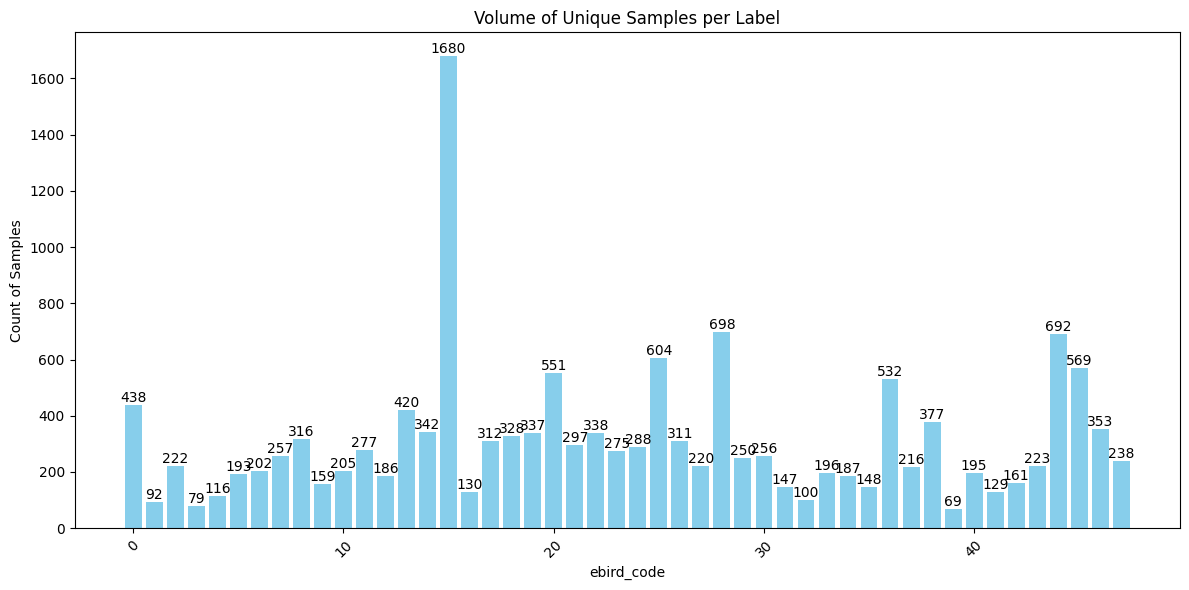

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [10]:
filtered_dataset = dataset["train"].filter(lambda example: example["length"] <= 5)


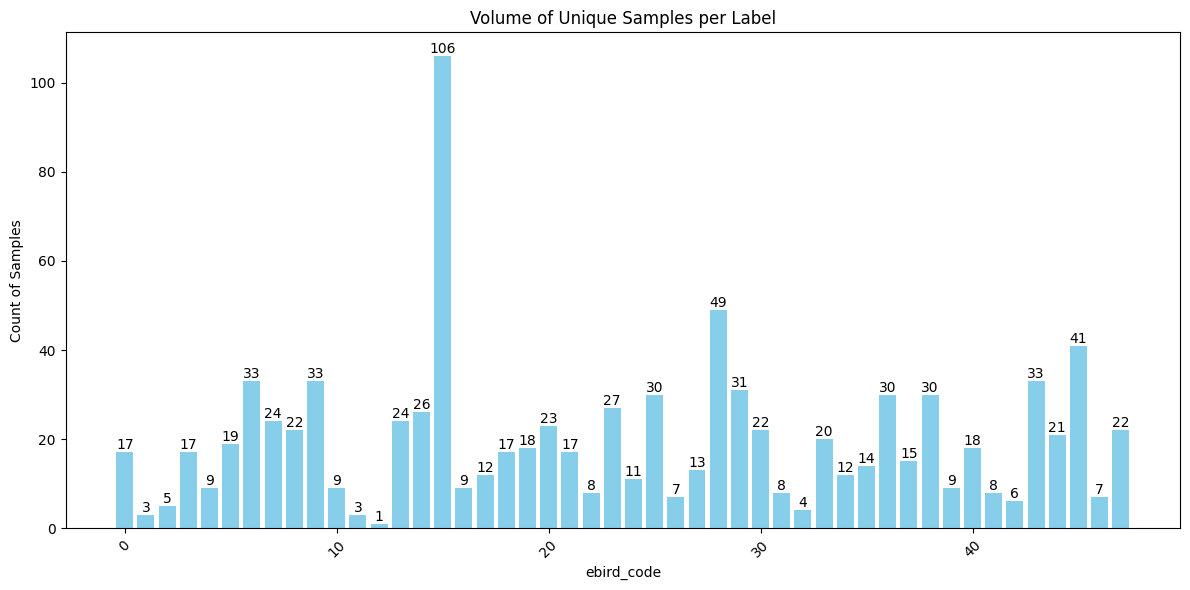

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

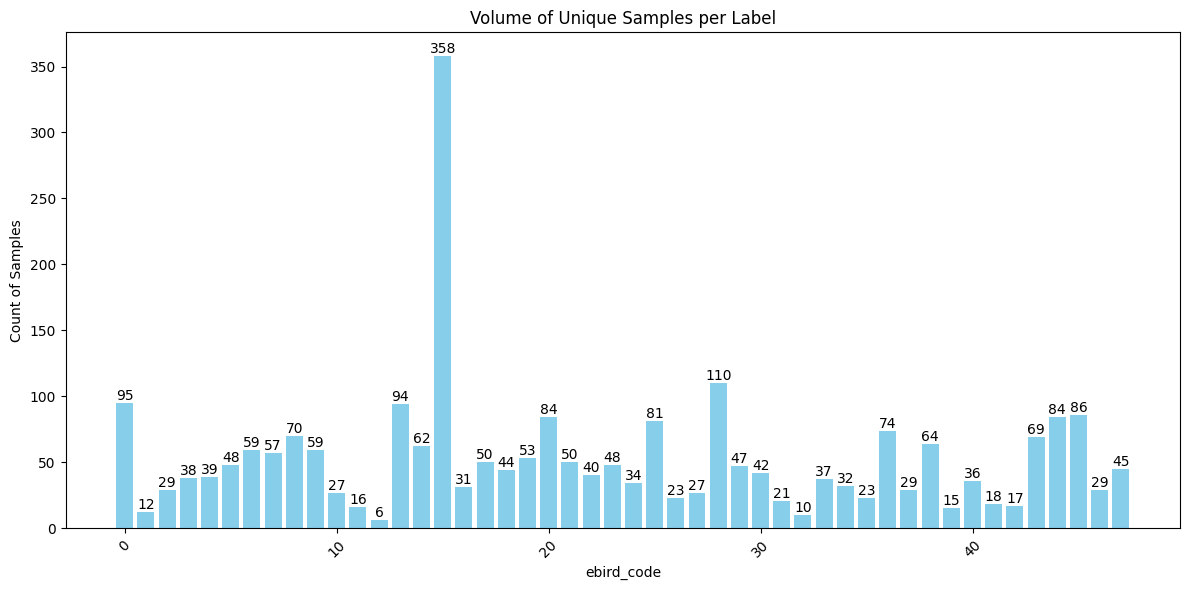

In [12]:
# filtered without secondary 

filtered_dataset = dataset["train"].filter(
    lambda example: (example["length"] <= 5) or (example["length"] <= 15 and example["ebird_code_secondary"] == [])
)
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in filtered_dataset]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [15]:
import random
import torch
from collections import defaultdict

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping

# ---------------------------
# Parameters (edit these)
# ---------------------------
DATASET_VARIANT = "POW"       # Options include "HSN", "POW", "SNE", etc.
NUM_CLASSES = 48              # Total number of classes in the dataset.
SHOT_COUNT = 5               # Maximum number of samples per class.
CACHE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}"
SAVE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}/{DATASET_VARIANT}_{SHOT_COUNT}shot"
REVISION = "629b54c06874b6d2fa886e1c0d73146c975612d0"
NUM_PROC = 1                  # Adjust number of processes if needed.

# ---------------------------
# Functions
# ---------------------------
def load_and_filter_dataset():
    """
    Loads the specified BirdSet variant and filters the train split.
    Recordings are kept if they are at most 5 seconds long, or if they are up to 20 seconds 
    and have no secondary label.
    """
    dataset = load_dataset(
        "DBD-research-group/BirdSet",
        DATASET_VARIANT,
        trust_remote_code=True,
        cache_dir=CACHE_DIR,
        num_proc=NUM_PROC,
        revision=REVISION,
    )
    filtered_train = dataset["train"].filter(
        lambda ex: (ex["length"] <= 5) or (ex["length"] <= 20 and ex["ebird_code_secondary"] == []),
        num_proc=NUM_PROC,
    )
    return DatasetDict({
        "train": filtered_train,
        "test": dataset["test_5s"]
    })

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    from the train split.
    """
    train_dataset = dataset_dict["train"]
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)
    selected_indices.sort()
    few_shot_train = train_dataset.select(selected_indices)
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train
    return new_dataset_dict

def fewshot_sampling(dataset):
    """
    Further reduces the train split by selecting only one sample per unique file.
    This avoids over-representation from recordings containing multiple events.
    """
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]
    return dataset.select(unique_file_indices)

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

# ---------------------------
# Main processing pipeline
# ---------------------------
def main():
    print("Loading and filtering dataset...", flush=True)
    dataset = load_and_filter_dataset()

    print("Creating few-shot dataset (max {} samples per class)...".format(SHOT_COUNT), flush=True)
    dataset = create_few_shot_dataset_dict(dataset, SHOT_COUNT)

    print("Casting audio column...", flush=True)
    dataset["train"] = dataset["train"].cast_column(
        "audio",
        Audio(sampling_rate=32000, mono=True, decode=False)
    )

    print("Mapping events...", flush=True)
    mapper = XCEventMapping()
    dataset["train"] = dataset["train"].map(
        mapper,
        remove_columns=["audio"],
        batched=True,
        batch_size=300,
        num_proc=NUM_PROC,
        desc="Train event mapping"
    )

    print("Applying few-shot sampling (one sample per unique file)...", flush=True)
    dataset["train"] = fewshot_sampling(dataset["train"])

    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]
    dataset = DatasetDict({
        split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
        for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    print("Saving processed dataset to disk...", flush=True)
    dataset.save_to_disk(SAVE_DIR)
    print("Dataset saved to", SAVE_DIR, flush=True)

In [16]:
main()

Loading and filtering dataset...
Creating few-shot dataset (max 5 samples per class)...
Casting audio column...
Mapping events...


Train event mapping:   0%|          | 0/240 [00:00<?, ? examples/s]

Applying few-shot sampling (one sample per unique file)...
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Saving processed dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/240 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4560 [00:00<?, ? examples/s]

Dataset saved to /home/lrauch/projects/birdMAE/data/POW/POW_5shot


### UHH

In [6]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "UHH", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/UHH", 
                       num_proc=1)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 3626
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 59583
    })
    test_5s: Dataset({
        features: [

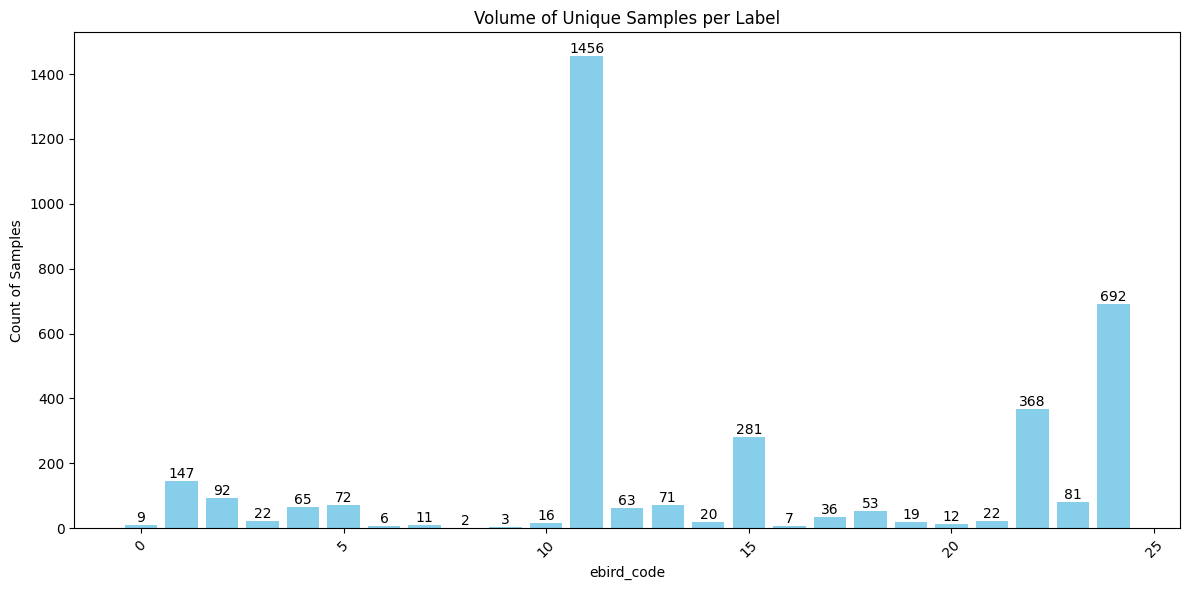

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [ ]:
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from datasets import load_from_disk

# initiate the data module
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir="/home/lrauch/projects/birdMAE/data/PER", # specify your data directory!
        hf_path='DBD-research-group/BirdSet',
        hf_name='PER',
        n_workers=1,
        val_split=0.0001,
        task="multilabel",
        classlimit=128, #limit of samples per class 
        eventlimit=2, #limit of events that are extracted for each sample
        sampling_rate=32_000,
    ),
)

In [9]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "PER", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/PER", 
                       num_proc=1)

Extracting train split:   0%|          | 0/11 [00:00<?, ?it/s]

Extracting test split:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting test_5s split:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test_5s split: 0 examples [00:00, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 16802
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 14798
    })
    test_5s: Dataset({
        features: 

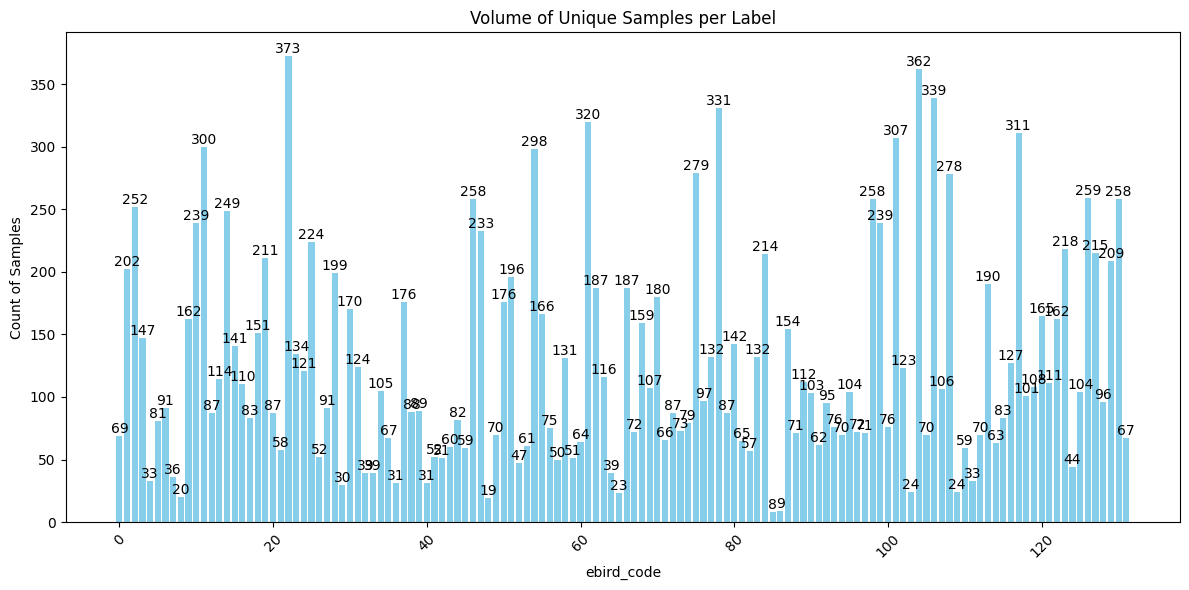

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [6]:
import random
import torch
from collections import defaultdict

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping

# ---------------------------
# Parameters (edit these)
# ---------------------------
DATASET_VARIANT = "PER"       # Options include "HSN", "POW", "SNE", etc.
NUM_CLASSES = 132              # Total number of classes in the dataset.
SHOT_COUNT = 16               # Maximum number of samples per class.
CACHE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}"
SAVE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}/{DATASET_VARIANT}_{SHOT_COUNT}shot"
#REVISION = "629b54c06874b6d2fa886e1c0d73146c975612d0"
REVISION = None
NUM_PROC = 1                  # Adjust number of processes if needed.

# ---------------------------
# Functions
# ---------------------------
def load_and_filter_dataset():
    """
    Loads the specified BirdSet variant and filters the train split.
    Recordings are kept if they are at most 5 seconds long, or if they are up to 20 seconds 
    and have no secondary label.
    """
    dataset = load_dataset(
        "DBD-research-group/BirdSet",
        DATASET_VARIANT,
        trust_remote_code=True,
        cache_dir=CACHE_DIR,
        num_proc=NUM_PROC,
        revision=REVISION,
    )
    filtered_train = dataset["train"].filter(
        lambda ex: (ex["length"] <= 5) or (ex["length"] <= 20 and ex["ebird_code_secondary"] == []),
        num_proc=NUM_PROC,
    )
    return DatasetDict({
        "train": filtered_train,
        "test": dataset["test_5s"]
    })

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    from the train split.
    """
    train_dataset = dataset_dict["train"]
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)
    selected_indices.sort()
    few_shot_train = train_dataset.select(selected_indices)
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train
    return new_dataset_dict

def fewshot_sampling(dataset):
    """
    Further reduces the train split by selecting only one sample per unique file.
    This avoids over-representation from recordings containing multiple events.
    """
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]
    return dataset.select(unique_file_indices)

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

# ---------------------------
# Main processing pipeline
# ---------------------------
def main():
    print("Loading and filtering dataset...", flush=True)
    dataset = load_and_filter_dataset()

    print("Creating few-shot dataset (max {} samples per class)...".format(SHOT_COUNT), flush=True)
    dataset = create_few_shot_dataset_dict(dataset, SHOT_COUNT)

    print("Casting audio column...", flush=True)
    dataset["train"] = dataset["train"].cast_column(
        "audio",
        Audio(sampling_rate=32000, mono=True, decode=False)
    )

    print("Mapping events...", flush=True)
    mapper = XCEventMapping()
    dataset["train"] = dataset["train"].map(
        mapper,
        remove_columns=["audio"],
        batched=True,
        batch_size=300,
        num_proc=NUM_PROC,
        desc="Train event mapping"
    )

    print("Applying few-shot sampling (one sample per unique file)...", flush=True)
    dataset["train"] = fewshot_sampling(dataset["train"])

    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]
    dataset = DatasetDict({
        split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
        for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    print("Saving processed dataset to disk...", flush=True)
    dataset.save_to_disk(SAVE_DIR)
    print("Dataset saved to", SAVE_DIR, flush=True)

In [7]:
main()

Loading and filtering dataset...
Creating few-shot dataset (max 16 samples per class)...
Casting audio column...
Mapping events...


Train event mapping:   0%|          | 0/1943 [00:00<?, ? examples/s]

Applying few-shot sampling (one sample per unique file)...
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Saving processed dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/1943 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Dataset saved to /home/lrauch/projects/birdMAE/data/PER/PER_16shot


In [1]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "NES", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/NES", 
                       num_proc=1)

Extracting train split:   0%|          | 0/13 [00:00<?, ?it/s]

Extracting test split:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting test_5s split:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test_5s split: 0 examples [00:00, ? examples/s]

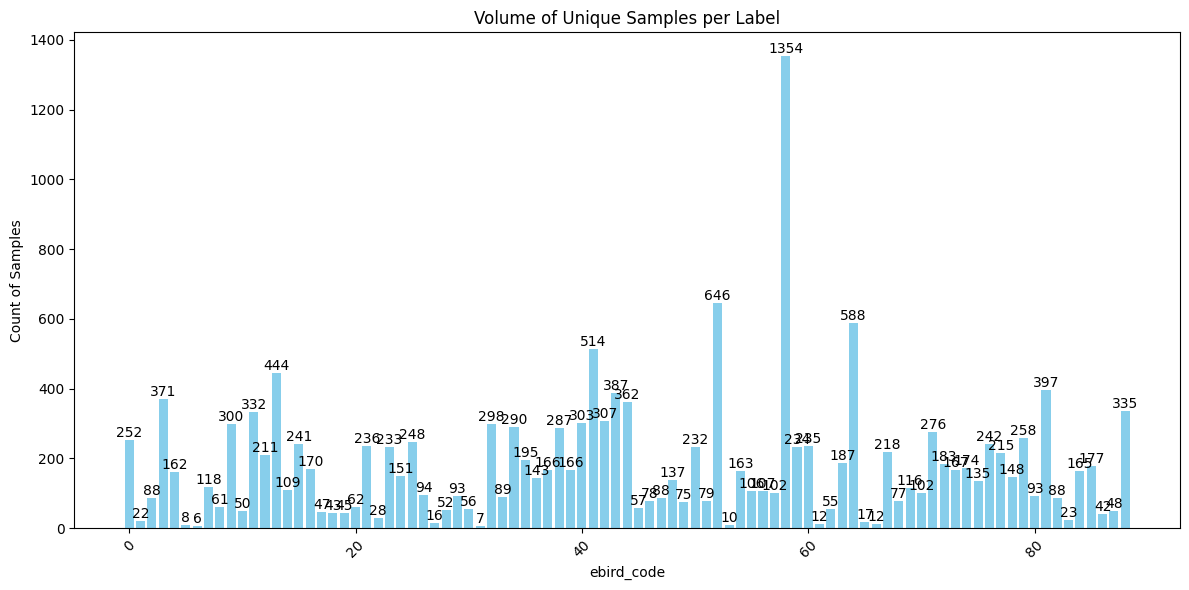

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [13]:
import random
import torch
from collections import defaultdict

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping

# ---------------------------
# Parameters (edit these)
# ---------------------------
DATASET_VARIANT = "HSN"       # Options include "HSN", "POW", "SNE", etc.
NUM_CLASSES = 21              # Total number of classes in the dataset.
SHOT_COUNT = 100               # Maximum number of samples per class.
CACHE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}"
SAVE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}/{DATASET_VARIANT}_{SHOT_COUNT}shot"
REVISION = "629b54c06874b6d2fa886e1c0d73146c975612d0"
#REVISION = None
NUM_PROC = 1                  # Adjust number of processes if needed.

# ---------------------------
# Functions
# ---------------------------
def load_and_filter_dataset():
    """
    Loads the specified BirdSet variant and filters the train split.
    Recordings are kept if they are at most 5 seconds long, or if they are up to 20 seconds 
    and have no secondary label.
    """
    dataset = load_dataset(
        "DBD-research-group/BirdSet",
        DATASET_VARIANT,
        trust_remote_code=True,
        cache_dir=CACHE_DIR,
        num_proc=NUM_PROC,
        revision=REVISION,
    )
    filtered_train = dataset["train"].filter(
        lambda ex: (ex["length"] <= 5) or (ex["length"] <= 20 and ex["ebird_code_secondary"] == []),
        num_proc=NUM_PROC,
    )
    return DatasetDict({
        "train": filtered_train,
        "test": dataset["test_5s"]
    })

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    from the train split.
    """
    train_dataset = dataset_dict["train"]
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)
    selected_indices.sort()
    few_shot_train = train_dataset.select(selected_indices)
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train
    return new_dataset_dict

def fewshot_sampling(dataset):
    """
    Further reduces the train split by selecting only one sample per unique file.
    This avoids over-representation from recordings containing multiple events.
    """
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]
    return dataset.select(unique_file_indices)

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

# ---------------------------
# Main processing pipeline
# ---------------------------
def main():
    print("Loading and filtering dataset...", flush=True)
    dataset = load_and_filter_dataset()

    print("Creating few-shot dataset (max {} samples per class)...".format(SHOT_COUNT), flush=True)
    dataset = create_few_shot_dataset_dict(dataset, SHOT_COUNT)

    print("Casting audio column...", flush=True)
    dataset["train"] = dataset["train"].cast_column(
        "audio",
        Audio(sampling_rate=32000, mono=True, decode=False)
    )

    print("Mapping events...", flush=True)
    mapper = XCEventMapping()
    dataset["train"] = dataset["train"].map(
        mapper,
        remove_columns=["audio"],
        batched=True,
        batch_size=300,
        num_proc=NUM_PROC,
        desc="Train event mapping"
    )

    print("length:",len(dataset["train"]))

    print("Applying few-shot sampling (one sample per unique file)...", flush=True)
    dataset["train"] = fewshot_sampling(dataset["train"])
    print("length:",len(dataset["train"]))

    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]
    dataset = DatasetDict({
        split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
        for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    print("Saving processed dataset to disk...", flush=True)
    dataset.save_to_disk(SAVE_DIR)
    print("Dataset saved to", SAVE_DIR, flush=True)

In [14]:
main()

Loading and filtering dataset...


Filter:   0%|          | 0/5460 [00:00<?, ? examples/s]

Creating few-shot dataset (max 100 samples per class)...
Casting audio column...
Mapping events...


Train event mapping:   0%|          | 0/1011 [00:00<?, ? examples/s]

length: 1526
Applying few-shot sampling (one sample per unique file)...
length: 1011
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving processed dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/1011 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Dataset saved to /home/lrauch/projects/birdMAE/data/HSN/HSN_100shot


In [1]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "SNE", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/SNE", 
                       num_proc=3)

Extracting train split:   0%|          | 0/21 [00:00<?, ?it/s]

Extracting test split:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting test_5s split:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Setting num_proc from 3 back to 1 for the test_5s split to disable multiprocessing as it only contains one shard.


Generating test_5s split: 0 examples [00:00, ? examples/s]

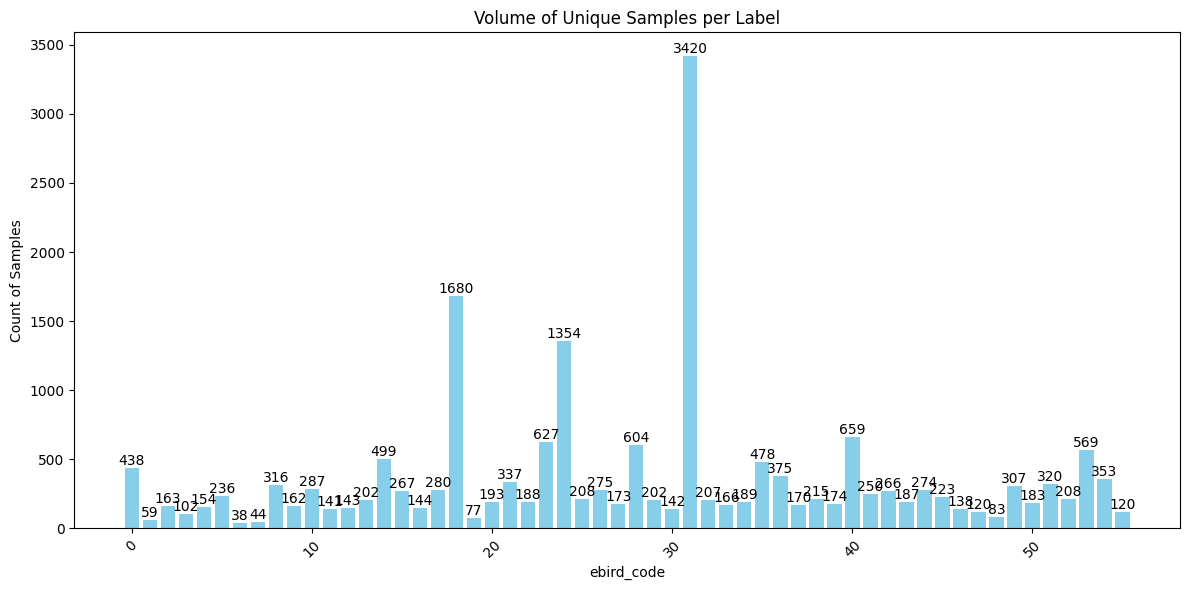

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [1]:
import random
import torch
from collections import defaultdict

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping

# ---------------------------
# Parameters (edit these)
# ---------------------------
DATASET_VARIANT = "SNE"       # Options include "HSN", "POW", "SNE", etc.
NUM_CLASSES = 56              # Total number of classes in the dataset.
SHOT_COUNT = 32               # Maximum number of samples per class.
CACHE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}"
SAVE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}/{DATASET_VARIANT}_{SHOT_COUNT}shot"
#REVISION = "629b54c06874b6d2fa886e1c0d73146c975612d0"
REVISION = None
NUM_PROC = 1                  # Adjust number of processes if needed.

# ---------------------------
# Functions
# ---------------------------
def load_and_filter_dataset():
    """
    Loads the specified BirdSet variant and filters the train split.
    Recordings are kept if they are at most 5 seconds long, or if they are up to 20 seconds 
    and have no secondary label.
    """
    dataset = load_dataset(
        "DBD-research-group/BirdSet",
        DATASET_VARIANT,
        trust_remote_code=True,
        cache_dir=CACHE_DIR,
        num_proc=NUM_PROC,
        revision=REVISION,
    )
    filtered_train = dataset["train"].filter(
        lambda ex: (ex["length"] <= 5) or (ex["length"] <= 20 and ex["ebird_code_secondary"] == []),
        num_proc=NUM_PROC,
    )
    return DatasetDict({
        "train": filtered_train,
        "test": dataset["test_5s"]
    })

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    from the train split.
    """
    train_dataset = dataset_dict["train"]
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)
    selected_indices.sort()
    few_shot_train = train_dataset.select(selected_indices)
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train
    return new_dataset_dict

def fewshot_sampling(dataset):
    """
    Further reduces the train split by selecting only one sample per unique file.
    This avoids over-representation from recordings containing multiple events.
    """
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]
    return dataset.select(unique_file_indices)

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

# ---------------------------
# Main processing pipeline
# ---------------------------
def main():
    print("Loading and filtering dataset...", flush=True)
    dataset = load_and_filter_dataset()

    print("Creating few-shot dataset (max {} samples per class)...".format(SHOT_COUNT), flush=True)
    dataset = create_few_shot_dataset_dict(dataset, SHOT_COUNT)

    print("Casting audio column...", flush=True)
    dataset["train"] = dataset["train"].cast_column(
        "audio",
        Audio(sampling_rate=32000, mono=True, decode=False)
    )

    print("Mapping events...", flush=True)
    mapper = XCEventMapping()
    dataset["train"] = dataset["train"].map(
        mapper,
        remove_columns=["audio"],
        batched=True,
        batch_size=300,
        num_proc=NUM_PROC,
        desc="Train event mapping"
    )

    print("length:",len(dataset["train"]))

    print("Applying few-shot sampling (one sample per unique file)...", flush=True)
    dataset["train"] = fewshot_sampling(dataset["train"])
    print("length:",len(dataset["train"]))

    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]
    dataset = DatasetDict({
        split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
        for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    print("Saving processed dataset to disk...", flush=True)
    dataset.save_to_disk(SAVE_DIR)
    print("Dataset saved to", SAVE_DIR, flush=True)

In [4]:
main()

Loading and filtering dataset...
Creating few-shot dataset (max 32 samples per class)...
Casting audio column...
Mapping events...


Train event mapping:   0%|          | 0/1573 [00:00<?, ? examples/s]

length: 2541
Applying few-shot sampling (one sample per unique file)...
length: 1573
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Saving processed dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/1573 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Dataset saved to /home/lrauch/projects/birdMAE/data/SNE/SNE_32shot


In [1]:
from datasets import load_dataset, Audio, DatasetDict

dataset = load_dataset("DBD-research-group/BirdSet", "XCM", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/XCM", 
                       num_proc=1,
                       revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

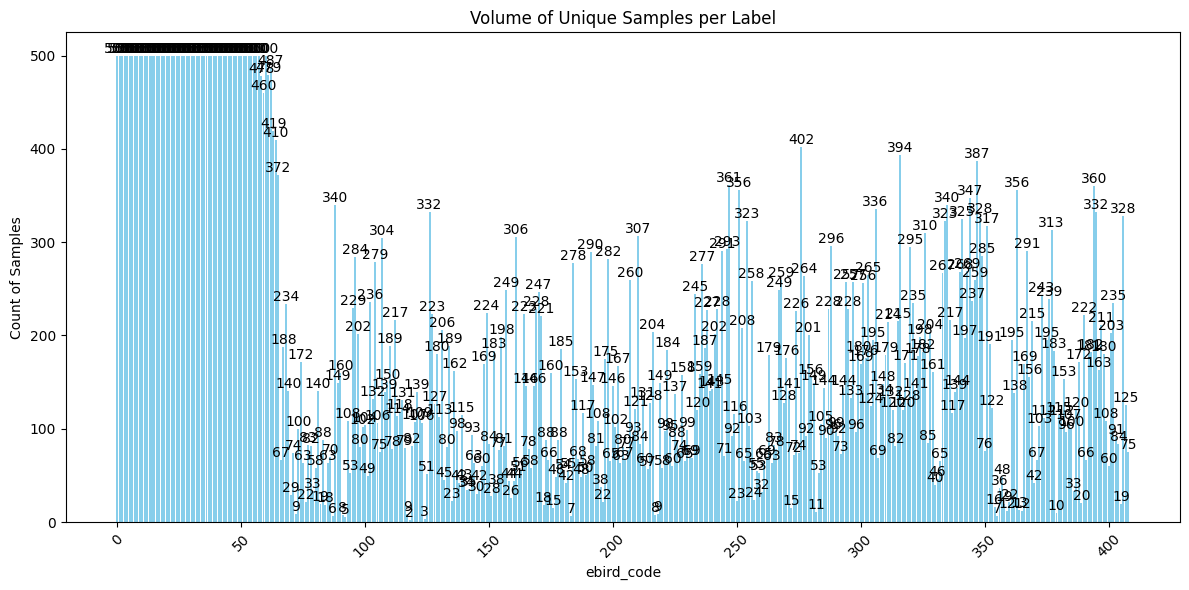

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Extract the ebird codes from the filtered dataset
labels = [example["ebird_code"] for example in dataset["train"]]

# Count how many times each label appears
label_counts = Counter(labels)

# Plot the counts
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("ebird_code")
plt.ylabel("Count of Samples")
plt.title("Volume of Unique Samples per Label")
plt.xticks(rotation=45)

# Add text annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height,                            # y position: at the top of the bar
        str(int(height)),                  # text: count as integer
        ha='center', va='bottom'           # horizontal & vertical alignment
    )

plt.tight_layout()
plt.show()

In [5]:
import random
import torch
from collections import defaultdict

from datasets import load_dataset, Audio, DatasetDict
from birdset.datamodule.components.event_mapping import XCEventMapping

# ---------------------------
# Parameters (edit these)
# ---------------------------
DATASET_VARIANT = "XCM"       # Options include "HSN", "POW", "SNE", etc.
NUM_CLASSES = 411             # Total number of classes in the dataset.
SHOT_COUNT = 64               # Maximum number of samples per class.
CACHE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}"
SAVE_DIR = f"/home/lrauch/projects/birdMAE/data/{DATASET_VARIANT}/{DATASET_VARIANT}_{SHOT_COUNT}shot"
REVISION = "629b54c06874b6d2fa886e1c0d73146c975612d0"
#REVISION = None
NUM_PROC = 1                  # Adjust number of processes if needed.

# ---------------------------
# Functions
# ---------------------------
def load_and_filter_dataset():
    """
    Loads the specified BirdSet variant and filters the train split.
    Recordings are kept if they are at most 5 seconds long, or if they are up to 20 seconds 
    and have no secondary label.
    """
    dataset = load_dataset(
        "DBD-research-group/BirdSet",
        DATASET_VARIANT,
        trust_remote_code=True,
        cache_dir=CACHE_DIR,
        num_proc=NUM_PROC,
        revision=REVISION,
    )
    filtered_train = dataset["train"].filter(
        lambda ex: (ex["length"] <= 5) or (ex["length"] <= 20 and ex["ebird_code_secondary"] == []),
        num_proc=NUM_PROC,
    )
    return DatasetDict({
        "train": filtered_train,
    })

def create_few_shot_dataset_dict(dataset_dict, shot_count, label_field="ebird_code"):
    """
    Creates a few-shot DatasetDict by randomly selecting up to `shot_count` samples per class
    from the train split.
    """
    train_dataset = dataset_dict["train"]
    label_to_indices = {}
    for idx, example in enumerate(train_dataset):
        label = example[label_field]
        label_to_indices.setdefault(label, []).append(idx)
    selected_indices = []
    for indices in label_to_indices.values():
        if len(indices) > shot_count:
            selected_indices.extend(random.sample(indices, shot_count))
        else:
            selected_indices.extend(indices)
    selected_indices.sort()
    few_shot_train = train_dataset.select(selected_indices)
    new_dataset_dict = dataset_dict.copy()
    new_dataset_dict["train"] = few_shot_train
    return new_dataset_dict

def fewshot_sampling(dataset):
    """
    Further reduces the train split by selecting only one sample per unique file.
    This avoids over-representation from recordings containing multiple events.
    """
    file_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        file_to_indices[sample["filepath"]].append(idx)
    unique_file_indices = [random.choice(indices) for indices in file_to_indices.values()]
    return dataset.select(unique_file_indices)

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

# ---------------------------
# Main processing pipeline
# ---------------------------
def main():
    print("Loading and filtering dataset...", flush=True)
    dataset = load_and_filter_dataset()

    print("Creating few-shot dataset (max {} samples per class)...".format(SHOT_COUNT), flush=True)
    dataset = create_few_shot_dataset_dict(dataset, SHOT_COUNT)

    print("Casting audio column...", flush=True)
    dataset["train"] = dataset["train"].cast_column(
        "audio",
        Audio(sampling_rate=32000, mono=True, decode=False)
    )

    print("Mapping events...", flush=True)
    mapper = XCEventMapping()
    dataset["train"] = dataset["train"].map(
        mapper,
        remove_columns=["audio"],
        batched=True,
        batch_size=300,
        num_proc=NUM_PROC,
        desc="Train event mapping"
    )

    print("length:",len(dataset["train"]))

    print("Applying few-shot sampling (one sample per unique file)...", flush=True)
    dataset["train"] = fewshot_sampling(dataset["train"])
    print("length:",len(dataset["train"]))

    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]
    dataset = DatasetDict({
        split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
        for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    print("Saving processed dataset to disk...", flush=True)
    dataset.save_to_disk(SAVE_DIR)
    print("Dataset saved to", SAVE_DIR, flush=True)

In [6]:
main()

Loading and filtering dataset...
Creating few-shot dataset (max 64 samples per class)...
Casting audio column...
Mapping events...


Train event mapping:   0%|          | 0/15445 [00:00<?, ? examples/s]

length: 28048
Applying few-shot sampling (one sample per unique file)...
length: 15445
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/15445 [00:00<?, ? examples/s]

Saving processed dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/15445 [00:00<?, ? examples/s]

Dataset saved to /home/lrauch/projects/birdMAE/data/XCM/XCM_64shot


In [1]:
from datasets import load_from_disk

dataset = load_from_disk("/home/lrauch/projects/birdMAE/data/XCM/XCM_64shot")

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 15445
    })
})

In [2]:
from datasets import DatasetDict, Dataset, concatenate_datasets, Sequence, Value
import random
from birdset.datamodule.components.event_mapping import XCEventMapping
import soundfile as sf


class BaseCondition:

    def __call__(self, dataset: Dataset, idx:int , **kwds) -> bool:
        return True
    

class LenientCondition(BaseCondition):

    def __call__(self, dataset: Dataset, idx: int, **kwds):
        """
        This condition allows files up to 10s but only if one bird occurence is in the file.
        """
        file_info = sf.info(dataset[idx]["filepath"])
        if file_info.duration <= 20 and (not dataset[idx]["ebird_code_secondary"]):
            return True
        
class StrictCondition(BaseCondition):

    def __call__(self, dataset: Dataset, idx: int, **kwds):
        """
        This condition only allows files that up to 5s long so that no event detection has to occur when sampling.
        """
        file_info = sf.info(dataset[idx]["filepath"])
        if file_info.duration <= 5:
            return True

def one_hot_encode_batch(batch, num_classes):
    """
    Converts integer class labels in a batch to one-hot encoded tensors.
    """
    label_list = batch["labels"]
    batch_size = len(label_list)
    one_hot = torch.zeros((batch_size, num_classes), dtype=torch.float32)
    for i, label in enumerate(label_list):
        one_hot[i, label] = 1
    return {"labels": one_hot}

def create_few_shot_subset(dataset: DatasetDict, few_shot: int=5, data_selection_condition: BaseCondition=StrictCondition(), fill_up: bool=False, random_seed: int=None) -> DatasetDict:
    """
    This method creates a subset of the given datasets train split with at max `few_shot` samples per label in the dataset split.
    The samples are chosen based on the given condition. If there are more than `few_shot` samples for a label `few_shot`
    random samples are chosen. If exactly `few_shot` samples per label are wanted, `fill_up` should be set to `True`.
    After the samples that pass the condition are added to the subset, this will randomly fill up the unfullfilled labels
    with their respective samples from the given dataset split without regard for the condition. 
    
    Args:
        dataset (DatasetDict): A Huggingface "datasets.DatasetDict" object. A few-shot subset will be created for the `train` split.
        few_shot (int): The number of samples each label can have. Default is 5.
        data_selection_condition (ConditionTemplate): A condition that defines which recordings should be included in the few-shot subset.
        fill_up (bool): If True, labels for which not enough samples can be extracted with the given condition will be supplemented with
          random samples from the dataset. Default is False.
        random_seed (int): The seed with which the random sampler is seeded. If None, no seeding is applied. Default is None.
    Returns:
        DatasetDict: A Huggingface `datasets.DatasetDict` object where the test split is return as it was given and the train
        split is replaced with the few-shot subset of the given train split.
    """
    if random_seed != None:
        print(f"Set random seed to {random_seed}.")
        random.seed(random_seed)
    train_split = dataset["train"]

    print("Applying condition to training data.")
    satisfying_recording_indeces = []
    for i in range(len(train_split)):
        if data_selection_condition(train_split, i):
            satisfying_recording_indeces.append(i)

    print("Mapping satisfying recordings.")
    all_labels = set(train_split["ebird_code"])
    primary_samples_per_label, leftover_samples_per_label = _map_recordings_to_samples(
        train_split,
        all_labels,
        satisfying_recording_indeces
    )

    print("Selecting samples for subset.")
    selected_samples = []
    unfullfilled_labels = {}
    for label, samples in primary_samples_per_label.items():
        num_primary_samples = len(samples)
        num_leftover_samples = len(leftover_samples_per_label[label])
        if (num_primary_samples + num_leftover_samples) < few_shot:
            selected_samples.extend(samples)
            selected_samples.extend(leftover_samples_per_label[label])
            unfullfilled_labels[label] = few_shot - (num_primary_samples + num_leftover_samples)
        elif num_primary_samples < few_shot:
            selected_samples.extend(samples)
            selected_samples.extend(random.sample(leftover_samples_per_label[label], k=(few_shot - num_primary_samples)))
        else:
            selected_samples.extend(random.sample(samples, few_shot))

    if fill_up:
        print("Filling up labels.")
        unused_recordings = set(range(len(train_split))).difference(satisfying_recording_indeces)
        unused_primary, unused_leftover = _map_recordings_to_samples(
            train_split,
            all_labels,
            unused_recordings
        )

        fill_up_samples = []
        for label, count in unfullfilled_labels.items():
            num_primary_samples = len(unused_primary[label])
            num_leftover_samples = len(unused_leftover[label])
            if num_primary_samples < count:
                fill_up_samples.extend(unused_primary[label])
                # if there are not enough samples in the dataset the min() has to be taken to avoid errors. 
                fill_up_samples.extend(random.sample(unused_leftover[label], k=min((count - num_primary_samples), num_leftover_samples)))
            else:
                fill_up_samples.extend(random.sample(unused_primary[label], count))
        selected_samples.extend(fill_up_samples)
    
    dataset = DatasetDict({"train": Dataset.from_list(selected_samples), "test": dataset["test_5s"]})


    print("Selecting relevant columns and renaming...", flush=True)
    columns_to_keep = ["filepath", "ebird_code_multilabel", "detected_events", "start_time", "end_time"]

    dataset = DatasetDict({
    split: dataset[split].select_columns(columns_to_keep).rename_column("ebird_code_multilabel", "labels")
    for split in dataset.keys()
    })

    print("Applying one-hot encoding to labels...", flush=True)
    dataset = dataset.map(lambda batch: one_hot_encode_batch(batch, NUM_CLASSES), batched=True)

    return dataset


def _map_recordings_to_samples(train_split: Dataset, all_labels: set, recording_indeces: list):
    """
    This method uses the XCEventMapping to extract samples from the recordings. It also splits
    the extracted samples into primary and leftover. Every recording has exaclty one primary sample,
    which is chosen randomly. All samples that are not a primary sample for a recording are saved as
    leftover samples.
    """
    mapper = XCEventMapping()
    primary_samples_per_label = {label: [] for label in all_labels}
    leftover_samples_per_label = {label: [] for label in all_labels}
    for idx in recording_indeces:
        mapped_batch = mapper({key: [value] for key, value in train_split[idx].items()})
        mapped_batch = _remove_duplicates(mapped_batch)
        # in cases where a recording produces multiple samples, choose one as the main sample 
        # to prioritise the selection of samples from differing recordings.
        num_samples = len(mapped_batch["filepath"])
        primary_sample = random.choice(range(num_samples))
        for i in range(num_samples):
            sample = {key: mapped_batch[key][i] for key in mapped_batch.keys()}
            if i == primary_sample:
                primary_samples_per_label[sample["ebird_code"]].append(sample)
            else:
                leftover_samples_per_label[sample["ebird_code"]].append(sample)
    return primary_samples_per_label, leftover_samples_per_label


def _remove_duplicates(batch: dict[str, ]):
    """
    This method removes basic duplicates samples from a batch. These are samples that
    are entirely included in another sample in the same batch. It only works correctly if all 
    samples in the batch are from the same recording.
    """
    removable_idx = set()
    num_samples = len(batch["filepath"])
    for b_idx in range(num_samples):
        for other_sample in range(b_idx + 1, num_samples):
            event_one = batch["detected_events"][b_idx]
            event_two = batch["detected_events"][other_sample]
            if event_one[0] < event_two[0] and event_one[1] > event_two[1]:
                removable_idx.add(other_sample)
            elif event_two[0] < event_one[0] and event_two[1] > event_one[1]:
                removable_idx.add(b_idx)

    new_batch = {}
    for key in batch.keys():
        new_batch[key] = []
        for b_idx in range(num_samples):
            if b_idx not in removable_idx:
                new_batch[key].append(batch[key][b_idx])

    return new_batch

In [ ]:

NAME = "HSN"

dataset = load_dataset("DBD-research-group/BirdSet", NAME, num_proc=1, revision=REVISION)

NUM_CLASSES = dataset["train"].features["ebird_code"].num_classes

hsn128 = create_few_shot_subset(dataset, 128, data_selection_condition=LenientCondition(), fill_up=True, random_seed=1)

In [10]:
from datasets import load_dataset
import torch 
dataset = load_dataset("DBD-research-group/BirdSet", "HSN", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/HSN", 
                       num_proc=1, 
                       revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

In [16]:
hsn128 = create_few_shot_subset(dataset, 128, data_selection_condition=LenientCondition(), fill_up=True, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Filling up labels.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/2609 [00:00<?, ? examples/s]

In [17]:
hsn128

DatasetDict({
    train: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 2609
    })
    test: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 12000
    })
})

In [18]:
hsn128.save_to_disk("/home/lrauch/projects/birdMAE/data/HSN/HSN_128shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/2609 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

In [5]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "POW", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/POW", 
                       num_proc=1, 
                       revision="629b54c06874b6d2fa886e1c0d73146c975612d0")

In [9]:
import torch 
pow64 = create_few_shot_subset(dataset, 48, data_selection_condition=LenientCondition(), fill_up=False, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/2145 [00:00<?, ? examples/s]

In [10]:
pow64.shape

{'train': (2145, 5), 'test': (4560, 5)}

In [11]:
pow64.save_to_disk("/home/lrauch/projects/birdMAE/data/POW/POW_48shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/2145 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4560 [00:00<?, ? examples/s]

In [12]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "NES", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/NES", 
                       num_proc=1)

In [19]:
NUM_CLASSES = 89
nes64 = create_few_shot_subset(dataset, 32, data_selection_condition=LenientCondition(), fill_up=False, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/2463 [00:00<?, ? examples/s]

In [20]:
nes64.shape

{'train': (2463, 5), 'test': (24480, 5)}

In [21]:
nes64.save_to_disk("/home/lrauch/projects/birdMAE/data/NES/NES_32shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/2463 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

In [22]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "PER", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/PER", 
                       num_proc=1)

In [25]:
NUM_CLASSES = 132
per48 = create_few_shot_subset(dataset, 48, data_selection_condition=LenientCondition(), fill_up=False, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/5116 [00:00<?, ? examples/s]

In [26]:
per48.shape

{'train': (5116, 5), 'test': (15120, 5)}

In [28]:
per48.save_to_disk("/home/lrauch/projects/birdMAE/data/PER/PER_48shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/5116 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

In [30]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "UHH", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/UHH", 
                       num_proc=1)

In [33]:
NUM_CLASSES = 27
uhh48 = create_few_shot_subset(dataset, 48, data_selection_condition=LenientCondition(), fill_up=True, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Filling up labels.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1041 [00:00<?, ? examples/s]

In [35]:
uhh48.shape

{'train': (1041, 5), 'test': (36637, 5)}

In [36]:
uhh48.save_to_disk("/home/lrauch/projects/birdMAE/data/UHH/UHH_48shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/1041 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

In [1]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "SNE", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/SNE", 
                       num_proc=1)

In [7]:
import torch
NUM_CLASSES = 56
sne32 = create_few_shot_subset(dataset, 64, data_selection_condition=LenientCondition(), fill_up=True, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Filling up labels.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/3584 [00:00<?, ? examples/s]

In [8]:
sne32.shape

{'train': (3584, 5), 'test': (23756, 5)}

In [9]:
sne32.save_to_disk("/home/lrauch/projects/birdMAE/data/SNE/SNE_64shot_nfill")

Saving the dataset (0/1 shards):   0%|          | 0/3584 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

In [11]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "NBP", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/NBP", 
                       num_proc=1)

In [12]:
import torch
NUM_CLASSES = 51
nbp48 = create_few_shot_subset(dataset, 128, data_selection_condition=LenientCondition(), fill_up=False, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/6328 [00:00<?, ? examples/s]

In [13]:
nbp48.shape

{'train': (6328, 5), 'test': (539, 5)}

In [14]:
nbp48.save_to_disk("/home/lrauch/projects/birdMAE/data/NBP/NBP_128shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/6328 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

In [1]:
from datasets import load_dataset

dataset = load_dataset("DBD-research-group/BirdSet", "SSW", 
                       trust_remote_code=True,cache_dir="/home/lrauch/projects/birdMAE/data/SSW", 
                       num_proc=1)



In [6]:
dataset["train"].features["ebird_code"].num_classes

81

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 28403
    })
    test: Dataset({
        features: ['audio', 'filepath', 'start_time', 'end_time', 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel', 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length', 'microphone', 'license', 'source', 'local_time', 'detected_events', 'event_cluster', 'peaks', 'quality', 'recordist', 'genus', 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel', 'order_multilabel'],
        num_rows: 50760
    })
    test_5s: Dataset({
        features: 

In [6]:
import torch
NUM_CLASSES = 81
ssw48 = create_few_shot_subset(dataset, 64, data_selection_condition=LenientCondition(), fill_up=False, random_seed=1)

Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/4524 [00:00<?, ? examples/s]

In [7]:
ssw48.shape

{'train': (4524, 5), 'test': (205200, 5)}

In [8]:
ssw48.save_to_disk("/home/lrauch/projects/birdMAE/data/SSW/SSW_64shot_n")

Saving the dataset (0/1 shards):   0%|          | 0/4524 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

In [1]:
import sys
import os

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from util.fewshot_generator import create_few_shot_subset

In [4]:
import os
from datasets import load_dataset
# Note: If NUM_CLASSES is used inside create_few_shot_subset,
# ensure it is either defined globally (if appropriate) or passed in.
import sys
import os

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from util.fewshot_generator import create_few_shot_subset, LenientCondition
# Define dataset names and optional revisions.
datasets_info = {
    # "HSN": {"revision": "629b54c06874b6d2fa886e1c0d73146c975612d0"},
    # "POW": {"revision": "629b54c06874b6d2fa886e1c0d73146c975612d0"},
     "NES": {},
     "PER": {},
     "SNE": {},
     "SSW": {},
     "UHH": {},
     "NBP": {},
}

# Define shot levels and seeds.
shot_numbers = [1, 5, 10]
seeds = [1, 2, 3]

# Base directory where the few-shot subsets will be saved.
base_save_path = "/home/lrauch/projects/birdMAE/data"

for ds_name, params in datasets_info.items():
    revision = params.get("revision")
    print(f"Loading dataset {ds_name}...")
    # Load dataset with revision if provided.
    if revision:
        ds = load_dataset("DBD-research-group/BirdSet", ds_name, num_proc=1, revision=revision,
                           cache_dir=os.path.join(base_save_path, ds_name))
    else:
        ds = load_dataset("DBD-research-group/BirdSet", ds_name, num_proc=1,
                          cache_dir=os.path.join(base_save_path, ds_name))

    # Compute NUM_CLASSES from the dataset's ClassLabel feature.
    NUM_CLASSES = ds["train"].features["ebird_code"].num_classes
    print(f"{ds_name} has {NUM_CLASSES} classes.")

    for shot in shot_numbers:
        for seed in seeds:
            print(f"Creating {shot}-shot subset for {ds_name} with seed {seed}...")
            few_shot_ds = create_few_shot_subset(
                ds,
                few_shot=shot,
                data_selection_condition=LenientCondition(),
                fill_up=False,
                random_seed=seed
            )
            # Define the saving path.
            save_dir = os.path.join(base_save_path, ds_name, f"{ds_name}_{shot}shot_{seed}")
            os.makedirs(os.path.dirname(save_dir), exist_ok=True)
            few_shot_ds.save_to_disk(save_dir)
            print(f"Saved {ds_name} {shot}-shot, seed {seed} subset to {save_dir}")

Loading dataset NES...
NES has 89 classes.
Creating 1-shot subset for NES with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Map:   0%|          | 0/24480 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NES/NES_1shot_1
Creating 1-shot subset for NES with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NES/NES_1shot_2
Creating 1-shot subset for NES with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/89 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NES/NES_1shot_3
Creating 5-shot subset for NES with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NES/NES_5shot_1
Creating 5-shot subset for NES with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NES/NES_5shot_2
Creating 5-shot subset for NES with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NES/NES_5shot_3
Creating 10-shot subset for NES with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NES/NES_10shot_1
Creating 10-shot subset for NES with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NES/NES_10shot_2
Creating 10-shot subset for NES with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/854 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24480 [00:00<?, ? examples/s]

Saved NES 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NES/NES_10shot_3
Loading dataset PER...
PER has 132 classes.
Creating 1-shot subset for PER with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Map:   0%|          | 0/15120 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/131 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/PER/PER_1shot_1
Creating 1-shot subset for PER with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/131 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/PER/PER_1shot_2
Creating 1-shot subset for PER with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/131 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/PER/PER_1shot_3
Creating 5-shot subset for PER with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/PER/PER_5shot_1
Creating 5-shot subset for PER with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/PER/PER_5shot_2
Creating 5-shot subset for PER with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/649 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/PER/PER_5shot_3
Creating 10-shot subset for PER with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/PER/PER_10shot_1
Creating 10-shot subset for PER with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/PER/PER_10shot_2
Creating 10-shot subset for PER with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1282 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Saved PER 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/PER/PER_10shot_3
Loading dataset SNE...
SNE has 56 classes.
Creating 1-shot subset for SNE with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/23756 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_1shot_1
Creating 1-shot subset for SNE with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_1shot_2
Creating 1-shot subset for SNE with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/56 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_1shot_3
Creating 5-shot subset for SNE with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_5shot_1
Creating 5-shot subset for SNE with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_5shot_2
Creating 5-shot subset for SNE with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_5shot_3
Creating 10-shot subset for SNE with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_10shot_1
Creating 10-shot subset for SNE with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_10shot_2
Creating 10-shot subset for SNE with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/559 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23756 [00:00<?, ? examples/s]

Saved SNE 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SNE/SNE_10shot_3
Loading dataset SSW...
SSW has 81 classes.
Creating 1-shot subset for SSW with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/205200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/81 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_1shot_1
Creating 1-shot subset for SSW with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/81 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_1shot_2
Creating 1-shot subset for SSW with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/81 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_1shot_3
Creating 5-shot subset for SSW with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_5shot_1
Creating 5-shot subset for SSW with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_5shot_2
Creating 5-shot subset for SSW with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/405 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_5shot_3
Creating 10-shot subset for SSW with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_10shot_1
Creating 10-shot subset for SSW with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_10shot_2
Creating 10-shot subset for SSW with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205200 [00:00<?, ? examples/s]

Saved SSW 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/SSW/SSW_10shot_3
Loading dataset UHH...
UHH has 27 classes.
Creating 1-shot subset for UHH with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Map:   0%|          | 0/36637 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_1shot_1
Creating 1-shot subset for UHH with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_1shot_2
Creating 1-shot subset for UHH with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_1shot_3
Creating 5-shot subset for UHH with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_5shot_1
Creating 5-shot subset for UHH with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_5shot_2
Creating 5-shot subset for UHH with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/97 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_5shot_3
Creating 10-shot subset for UHH with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_10shot_1
Creating 10-shot subset for UHH with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_10shot_2
Creating 10-shot subset for UHH with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/178 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/36637 [00:00<?, ? examples/s]

Saved UHH 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/UHH/UHH_10shot_3
Loading dataset NBP...
NBP has 51 classes.
Creating 1-shot subset for NBP with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/51 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 1-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_1shot_1
Creating 1-shot subset for NBP with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/51 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 1-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_1shot_2
Creating 1-shot subset for NBP with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/51 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 1-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_1shot_3
Creating 5-shot subset for NBP with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 5-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_5shot_1
Creating 5-shot subset for NBP with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 5-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_5shot_2
Creating 5-shot subset for NBP with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/255 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 5-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_5shot_3
Creating 10-shot subset for NBP with seed 1...
Set random seed to 1.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 10-shot, seed 1 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_10shot_1
Creating 10-shot subset for NBP with seed 2...
Set random seed to 2.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 10-shot, seed 2 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_10shot_2
Creating 10-shot subset for NBP with seed 3...
Set random seed to 3.
Applying condition to training data.
Mapping satisfying recordings.
Selecting samples for subset.
Selecting relevant columns and renaming...
Applying one-hot encoding to labels...


Map:   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/510 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/539 [00:00<?, ? examples/s]

Saved NBP 10-shot, seed 3 subset to /home/lrauch/projects/birdMAE/data/NBP/NBP_10shot_3
